In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from astropy.io import fits
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import light_curve as lc
plt.style.use('seaborn-whitegrid')

In [3]:
# main dataframe with all info
df = pd.read_csv('data/gbmdatacleaned.csv', index_col=0)

In [4]:
# dataframe with reference and target GRB info
newdf = pd.read_csv('data/distance_dat_file.csv')

In [5]:
def get_subset_df(fulldf, sub_df):
    ref_rows = []
    ref_idx = []
    for i in range(sub_df.shape[0]):
        x = sub_df.iloc[i].name
        df1 = fulldf[:x]
        ref_row = df1[df1['Is Reference'] == 1].iloc[-1]
        if ref_row.Index not in ref_idx:
            ref_rows.append(ref_row)
            ref_idx.append(ref_row.Index)
    df2 = pd.DataFrame(ref_rows)
    return pd.concat([sub_df, df2], sort=False).sort_index()

In [6]:
def get_dict_from_df(df):
    dct = dict()
    isref = df['Is Reference'].values
    idx = df['Index'].values
    for i, (x,y) in enumerate(zip(isref, idx)):
        if x:
            i += 1
            ls = []
            while i < len(isref) and isref[i] == 0:
                ls.append(idx[i])
                i += 1
            dct[y] = ls
    
    return dct

In [7]:
def get_fit_file(name):
    d = newdf.loc[newdf['Name'] == name]['Brightest Detector'].values[0]
    # try suffix _v01 or _v00
    dig = 0
    path = ''
    while not os.path.exists(path):
        path = 'C:/Users/hhsud/Downloads/GRBS/glg_tte_' + d + '_bn' + name[3:] + '_v0' + str(dig) + '.fit'
        dig += 1
        if dig > 100:
            print(path)
            raise FileNotFoundError

    return fits.open(path)

In [8]:
result_subdf = newdf.loc[newdf.Sigma < 0.5, :]
resultdf = get_subset_df(newdf, result_subdf)

In [9]:
list(resultdf[resultdf['Is Reference'] == 0].Sigma)

[0.094, 0.496, 0.029, 0.329, 0.125, 0.029]

In [10]:
list(resultdf[resultdf['Is Reference'] == 0].Name)

['GRB110911071',
 'GRB081006872',
 'GRB180412425',
 'GRB150404733',
 'GRB111107035',
 'GRB090510325']

In [11]:
list(resultdf[resultdf['Is Reference'] == 1].Name)

['GRB120114433',
 'GRB200908886',
 'GRB211219910',
 'GRB190906767',
 'GRB180630335',
 'GRB220124074']

In [12]:
pairs_value = [16, 1260]
label_value = ['Less than 2 sigma', 'Pairs Analyzed']

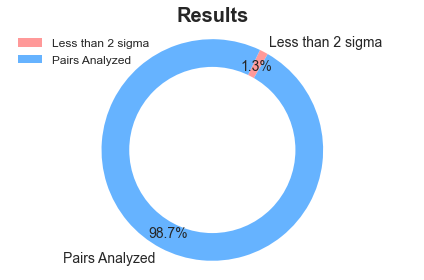

In [13]:
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.05,0.05)

fig1, ax1 = plt.subplots()
ax1.pie(pairs_value, colors = colors, labels=label_value, autopct='%.1f%%', 
        pctdistance=0.85, startangle=60, textprops={'fontsize':14})
#draw circle
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
ax1.set_title('Results', fontsize=20, fontweight='bold')
ax1.legend(loc='upper left', fontsize=12) 
plt.tight_layout()
plt.show()

In [14]:
dct = get_dict_from_df(resultdf)

In [15]:
delays = []
for i, (key, value) in enumerate(dct.items()):
    ref_time = datetime.strptime(df.trigger_time.iloc[key], '%Y-%m-%d %H:%M:%S.%f')
    delays.append(None)
    for x in value:
        tar_time = datetime.strptime(df.trigger_time.iloc[x], '%Y-%m-%d %H:%M:%S.%f')
        delay = abs(ref_time - tar_time)
        delays.append(delay)

In [16]:
resultdf['Delay'] = delays

In [17]:
resultdf

,Index,Is Reference,Name,Brightest Detector,ra,dec,t90,Binsize,Distance,Sigma,Delay
214,49,1,GRB120114433,n0,263.23,-75.64,2.752,1.0,0.0,NaN,NaT
215,56,0,GRB110911071,n2,258.58,-66.98,8.960,1.0,570.0,0.094,125 days 08:41:57.646000
266,57,1,GRB200908886,n0,169.53,-66.97,6.144,1.0,0.0,NaN,NaT
275,271,0,GRB081006872,n6,172.20,-61.00,3.328,1.0,656.0,0.496,4355 days 00:20:05.836000
397,75,1,GRB211219910,n2,68.54,-63.18,73.729,1.0,0.0,NaN,NaT
413,309,0,GRB180412425,n6,62.32,-59.01,20.992,1.0,2281.0,0.029,1347 days 11:37:40
600,103,1,GRB190906767,n4,171.84,-71.57,23.040,1.0,0.0,NaN,NaT
601,157,0,GRB150404733,n8,165.91,-67.37,4.864,1.0,1068.0,0.329,1616 days 00:50:05.569000
757,123,1,GRB180630335,n0,133.07,-69.94,48.896,1.0,0.0,NaN,NaT
760,171,0,GRB111107035,n8,129.48,-66.52,12.032,1.0,1573.0,0.125,2427 days 07:12:33.579000


In [18]:
def roundl(x):
    return [round(y,3) for y in x]

In [19]:
delaysns =  resultdf.Delay[resultdf.Delay.notna()].values
delayss = delaysns/np.timedelta64(1, 's')
delaydays = delaysns / np.timedelta64(1, 'D')
roundl(delaydays)

[125.362, 4355.014, 1347.484, 1616.035, 2427.3, 4641.75]

In [20]:
SPEED_OF_LIGHT = 3*(10**8)
GRAVITATIONAL_CONSTANT = 6.673*(10**-11)
def mass_of_lens(t):
    return t * SPEED_OF_LIGHT**3 / GRAVITATIONAL_CONSTANT

In [21]:
masses = list(map(mass_of_lens, delayss))
masses

[4.382520252390229e+42,
 1.5224601464966284e+44,
 4.710642619511464e+43,
 5.649461936704632e+43,
 8.485548249112842e+43,
 1.6226994356421397e+44]

### Plots of light curve with $\sigma < 3$
Legend : <br>
Blue = Reference <br>
Green = Target

In [22]:
def make_hist(ref, ref_name, tar, tar_name, info_tuple):
    df_ref = lc.df_from_fit_file(ref)
    df_tar = lc.df_from_fit_file(tar)
    t90_ref = lc.get_t90(ref_name)
    t90_tar = lc.get_t90(tar_name)
    start1 = -10
    end1 = max(t90_ref, t90_tar) + 10
    size1 = 0.1 if t90_ref < 2 else 1
    size2 = 0.1 if t90_tar < 2 else 1
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle(f'Distance : {info_tuple[0]}, Sigma : {info_tuple[1]}, Delay : {info_tuple[2]}', fontsize=16)
    ref = axs[0].hist(df_ref.TTIME, bins=int((end1 - start1)/size1), range=(start1,end1),
                label = ref_name, histtype='step', color='b')
    
    tar = axs[1].hist(df_tar.TTIME, bins=int((end1 - start1)/size2), range=(start1,end1),
                label = tar_name, histtype='step', color='g')

    axs[0].set_ylim([1000,1600])
    axs[1].set_ylim([1000,1600])

    fig.supxlabel('Time')
    fig.supylabel('Counts per sec')
    ref[2][0].set_xy(ref[2][0].get_xy()[1:])
    tar[2][0].set_xy(tar[2][0].get_xy()[1:])
    ref[2][0].set_xy(ref[2][0].get_xy()[:-1])
    tar[2][0].set_xy(tar[2][0].get_xy()[:-1])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)
    fig.legend(bbox_to_anchor=(0.9,0.5), borderaxespad=0, labels=[ref_name, tar_name], loc='center right')

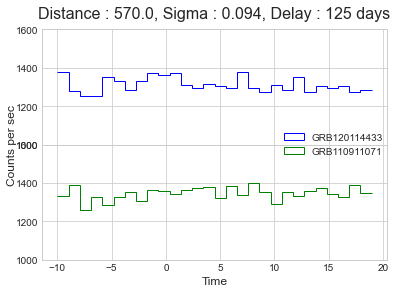

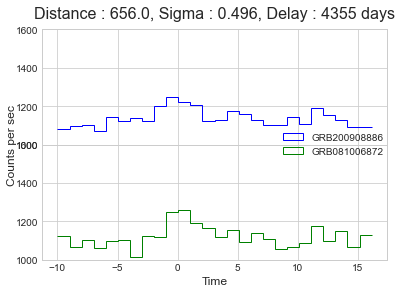

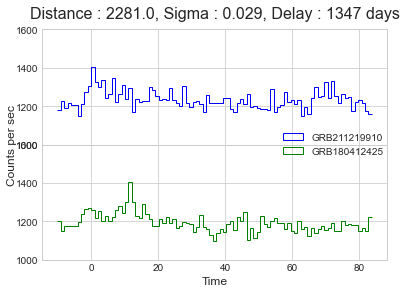

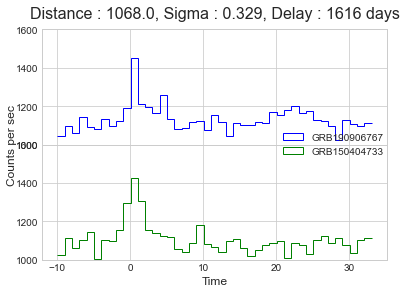

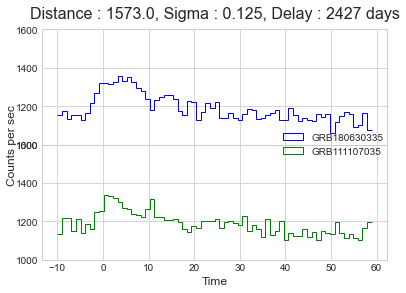

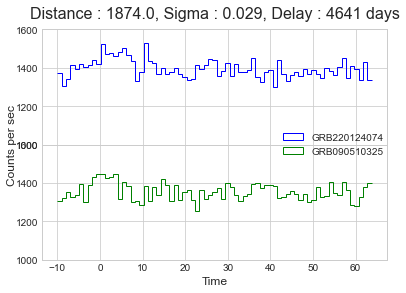

In [23]:
for i, (key, value) in enumerate(dct.items()):
    ref_name = resultdf[resultdf.Index == key]['Name'].values[0]
    ref = get_fit_file(ref_name)
    for x in value:
        tar_name = resultdf[resultdf.Index == x]['Name'].values[0]
        tar = get_fit_file(tar_name)
        row = resultdf.loc[resultdf.Index == x]
        info_tuple = (row.Distance.values[0], row.Sigma.values[0], 
                    row.Delay.values[0].astype("timedelta64[D]"))
        make_hist(ref, ref_name, tar, tar_name, info_tuple)

### Time delay vs $\sigma$

In [24]:
sub_df2 = resultdf.loc[resultdf.Sigma < 0.5, :]
df1 = get_subset_df(newdf, sub_df2) 

In [25]:
df1['Delay_day'] = df1.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [26]:
fig = px.scatter(df1, x='Delay_day', y=df1['Sigma'], labels={'Delay_day':'Days'})
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 250
    ),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.25
    )
)
fig.show()

### T90 ref vs T90 target

In [27]:
t90x = []
t90y = []
t90x_err = []
t90y_err = []
sigma_less_1 = []
for key, value in dct.items():
    a = resultdf.loc[resultdf.Index == key].t90.values[0]
    errx = float(df.iloc[key].t90_error)
    for x in value:
        row = resultdf.loc[resultdf.Index==x]
        b = row.t90.values[0]
        t90x.append(a)
        t90y.append(b)
        t90x_err.append(errx)
        t90y_err.append(float(df.iloc[x].t90_error))
        sigma_less_1.append(row.Sigma.values[0] < 1)

In [28]:
plotdf_t90 = pd.DataFrame({'x':t90x, 'y':t90y, 'sigma_less_1':sigma_less_1})

In [29]:
plotdf_t90['logx'] = np.log(plotdf_t90.x)
plotdf_t90['logy'] = np.log(plotdf_t90.y)

In [30]:
import numpy as np

In [32]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(18,8))
# ax = sns.scatterplot(data=plotdf_t90, x='x', y='y', hue='sigma_less_1', s=100)
# # m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
# # sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
# plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='b', linewidth=1)
# handles, labels  =  ax.get_legend_handles_labels()
# ax.set_title('T90 Reference vs Target with errors',fontsize=40)
# ax.set_ylabel('Target GRB', fontsize=20)
# ax.set_xlabel('Reference GRB', fontsize=20)
# ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=16)

In [33]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(20,10))
# ax = sns.scatterplot(data=plotdf_t90, x='logx', y='logy', hue='sigma_less_1', s=100)
# # m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
# # sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
# # plt.errorbar(plotdf_t90.logx, plotdf_t90.logy, xerr=np.log(np.array(t90x_err)), yerr=np.log(np.array(t90y_err)), fmt='none', ecolor='b', linewidth=1)
# handles, labels  =  ax.get_legend_handles_labels()
# ax.set_title('T90 Reference vs Target with errors',fontsize=40)
# ax.set_ylabel('Target GRB', fontsize=20)
# ax.set_xlabel('Reference GRB', fontsize=20)
# ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=16)

In [86]:
from scipy.optimize import curve_fit

def powerlaw(x, a, b) :
    return a * np.power(x, b)

In [87]:
popt, pcov = curve_fit(powerlaw, plotdf_t90.x, plotdf_t90.y)
fittedy = [powerlaw(x, popt[0], popt[1]) for x in plotdf_t90.x]

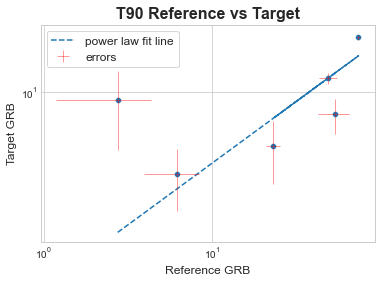

In [88]:
sns.set_style("whitegrid")
ax = sns.scatterplot(data=plotdf_t90, x='x', y='y')
plt.plot(plotdf_t90.x, fittedy, '--', label='power law fit line')
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('T90 Reference vs Target', fontweight='bold', fontsize=16)
plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='r', linewidth=1, alpha=0.4,
            label='errors')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Target GRB', fontsize=12)
ax.set_xlabel('Reference GRB', fontsize=12)
ax.legend(frameon=True, fontsize=12)

In [37]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(18,8))
# ax = sns.scatterplot(data=plotdf_t90, x='x', y='y', hue='sigma_less_1', s=100)
# m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
# sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
# plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='b', linewidth=1)
# handles, labels  =  ax.get_legend_handles_labels()
# ax.set_title('T90 Reference vs Target with regression line',fontsize=30)
# ax.set_ylabel('Target T90', fontsize=16)
# ax.set_xlabel('Reference T90', fontsize=16)
# ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=12)

### Fluence ref vs Fluence target

In [89]:
fluencex = []
fluencey = []
fx_err = []
fy_err = []
sigma_less_1 = []
for key, value in dct.items():
    a = df.iloc[key].fluence
    for x in value:
        row = resultdf.loc[resultdf.Index == x]
        b = df.iloc[x].fluence
        fluencex.append(a)
        fluencey.append(b)
        fx_err.append(df.iloc[key].fluence_error)
        fy_err.append(df.iloc[x].fluence_error)
        sigma_less_1.append(row.Sigma.values[0] < 1)

In [90]:
def floatify(arr):
    return [float(x) for x in arr]

In [91]:
fluencex = floatify(fluencex)
fluencey = floatify(fluencey)
fx_err = floatify(fx_err)
fy_err = floatify(fy_err)

In [92]:
plotdf_fluence = pd.DataFrame({'x':fluencex, 'y':fluencey, 'x_err':fx_err, 'y_err':fy_err})

In [93]:
plotdf_fluence['logx'] = np.log(plotdf_fluence.x)
plotdf_fluence['logy'] = np.log(plotdf_fluence.y)

In [94]:
from scipy.optimize import curve_fit

def powerlaw(x, a, b) :
    return a * np.power(x, b)

In [95]:
popt, pcov = curve_fit(powerlaw, plotdf_fluence.x, plotdf_fluence.y)
fittedy = [powerlaw(x, popt[0], popt[1]) for x in plotdf_fluence.x]

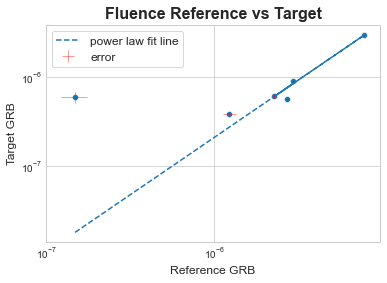

In [96]:
ax = sns.scatterplot(data=plotdf_fluence, x='x', y='y')
plt.plot(plotdf_fluence.x, fittedy, '--', label='power law fit line')
plt.errorbar(plotdf_fluence.x, plotdf_fluence.y, xerr=fx_err, yerr=fy_err, fmt='none', ecolor='r', linewidth=1, alpha=0.4
            ,label='error')
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('Fluence Reference vs Target', fontweight='bold', fontsize=16)
ax.set_ylabel('Target GRB', fontsize=12)
ax.set_xlabel('Reference GRB', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=True, fontsize=12)
# ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True)

### Distribution of delays

In [45]:
sub_df3 = resultdf.loc[resultdf.Sigma < 0.5, :]
df2 = get_subset_df(newdf, sub_df3) 

In [46]:
df2['Delay_day'] = df2.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [47]:
delay_days = [x for x in df2.Delay_day if not np.isnan(x)]

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 1')

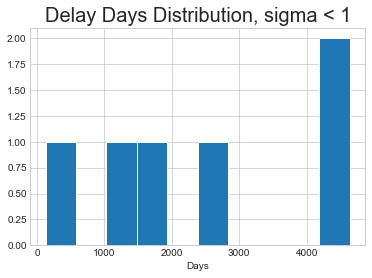

In [48]:
plt.hist(delay_days)
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 1', fontsize=20)

In [49]:
resultdf['Delay_day'] = resultdf.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [50]:
delay_days = [x for x in resultdf.Delay_day if not np.isnan(x)]

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 3')

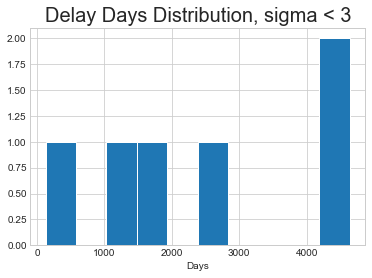

In [51]:
plt.hist(delay_days)
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 3', fontsize=20)